# DAT300 - Compulsory assignment 2

# Introduction

We were provided with a dataset of images of trees that were taken from above. The training dataset had a lenth of 4000. The task was to train Unet model and a transfer learning that will classify each pixel in the image as birch tree or not. If the pixel is a birch tree pixel the model will provide a result of 1 otherwise 0. Furthermore, we submitted a job to Orion i.e NMBU's distributed system.

# Data handling and visualisation

In [1]:
# Import and extraction of data.
import numpy as np # linear algebra
import pandas as pd


import h5py
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

import os
for dirname, _, filenames in os.walk('../input/dat300ca2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Extract train data
train_data_path = "../input/dat300ca2/tree_train.h5/tree_train.h5"
train_data = h5py.File(train_data_path, 'r')
print(train_data.keys())
X = train_data['X'][:]
y = train_data['y'][:]

print(X.shape)
print(y.shape)

../input/dat300ca2/tree_train.h5/tree_train.h5
../input/dat300ca2/tree_test.h5/tree_test.h5
<KeysViewHDF5 ['X', 'y']>
(4000, 128, 128, 3)
(4000, 128, 128, 1)


The training dataset has a total of 4000 birch tree images, each of these has a dimension of (128x128) pixels and has 3 channel. The ground truth (y) has the same dimensions but just 1 channel.

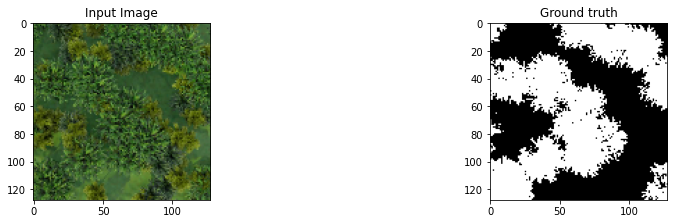

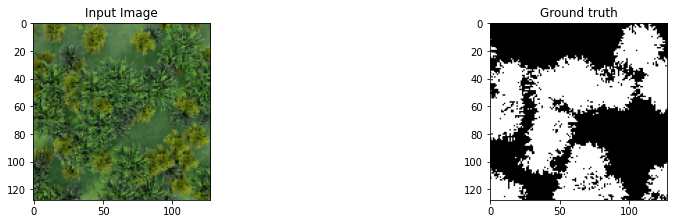

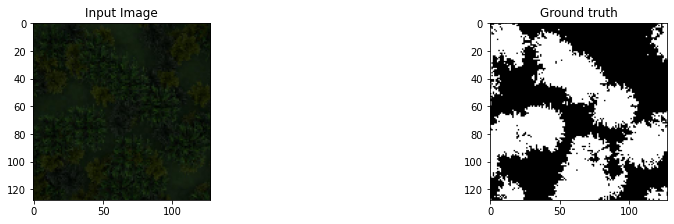

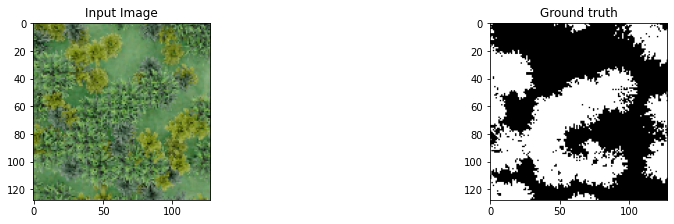

In [2]:
# Short exploration and visualisation of dataset (point 1 in Canvas).
i=1
for num in range(4):   
    plt.figure(figsize = (15,15))
    plt.subplot(420+i) # Shorthand for size 3x3, position i
    i+=1
    image = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.title('Input Image')
    plt.imshow(image)
    plt.subplot(420+i)
    image = y[i]
    plt.title('Ground truth')
    plt.imshow(image, cmap = 'gray')
    i+=1
plt.show()

In the ground truths, birch trees are segmented in white while everything else is masked with black. Apart from ground, there´re other trees in the images as well, so it would be challenging for any classifier to distinguish between them. The edges could be another challenge as they´re hard to distinguish.

# Methods

For modeling we have used 90% of the train data for training while have used the rest for validation at the later stage. We have trained UNet and a VGG-16 models separately using different combinations of parameters randomly, which includes batch size, epochs, learning rate, number of filters and dropouts and manually tuned them to get optimised results. The plan was to use random grid search to auto tune parameters but due to shortage of time we could not acheive that.
We also tried models with different convolutional layers and chose the best performing one.

## Data split and Normalization

In [3]:
# Split train data reserving 10% for testing
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
shape = X_train[0].shape

In [4]:
X_train = X_train/255.
X_test = X_test/255.

## UNet

In [5]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 1):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [6]:
input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 64, dropout = 0.01, batchnorm = False, n_classes = 1)

model.compile(optimizer = Adam(learning_rate= 0.001), loss = binary_crossentropy, metrics = ['accuracy'])

2021-11-29 17:58:56.474492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 17:58:56.570612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 17:58:56.571377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 17:58:56.572485: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=32,
            epochs=50,
            shuffle=True,
            verbose=1,
            validation_data=(X_test, y_test))

2021-11-29 17:58:59.386182: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2021-11-29 17:59:00.297981: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2021-11-29 17:59:00.837302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-29 17:59:03.048316: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


113/113 [==============================] - 41s 257ms/step - loss: 0.4550 - accuracy: 0.7811 - val_loss: 0.2583 - val_accuracy: 0.8976
Epoch 2/50
113/113 [==============================] - 26s 233ms/step - loss: 0.4632 - accuracy: 0.8109 - val_loss: 0.2853 - val_accuracy: 0.8869
Epoch 3/50
113/113 [==============================] - 26s 233ms/step - loss: 0.2491 - accuracy: 0.9025 - val_loss: 0.2452 - val_accuracy: 0.9026
Epoch 4/50
113/113 [==============================] - 26s 233ms/step - loss: 0.2106 - accuracy: 0.9152 - val_loss: 0.1999 - val_accuracy: 0.9203
Epoch 5/50
113/113 [==============================] - 26s 233ms/step - loss: 0.1910 - accuracy: 0.9225 - val_loss: 0.1794 - val_accuracy: 0.9268
Epoch 6/50
113/113 [==============================] - 26s 233ms/step - loss: 0.1749 - accuracy: 0.9291 - val_loss: 0.1669 - val_accuracy: 0.9321
Epoch 7/50
113/113 [==============================] - 26s 233ms/step - loss: 0.1634 - accuracy: 0.9336 - val_loss: 0.1574 - val_accuracy: 0.9

## Transfer learning model(VGG-16)

In [8]:
inputs = Input((128,128,3))
vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def build_vgg(input_shape, n_filters=64, dropout = 0.01, batchnorm = True):
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in vgg16.layers:
        layer.trainable = False
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (128 x 128)
    s2 = vgg16.get_layer("block2_conv2").output         ## (64 x 64)
    s3 = vgg16.get_layer("block3_conv3").output         ## (132 x 32)
    s4 = vgg16.get_layer("block4_conv3").output         ## (16 x 16)
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (8 x 8)
    
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(b1)
    u6 = concatenate([u6, s4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, s3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, s2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, s1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    
    

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(c9)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    
    return model

In [10]:
vgg_unet = build_vgg(inputs,batchnorm = False)
vgg_unet.compile(optimizer = Adam(learning_rate = 0.001), loss = binary_crossentropy, metrics = ['accuracy'])
# Fit data to model
history2 = vgg_unet.fit(X_train, y_train,
            batch_size=32,
            epochs=50,
            shuffle=True,
            verbose=1,
            validation_data=(X_test, y_test))

2021-11-29 18:21:26.556824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.
2021-11-29 18:21:27.444722: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 707788800 exceeds 10% of free system memory.


Epoch 1/50
113/113 [==============================] - 22s 184ms/step - loss: 0.4583 - accuracy: 0.8327 - val_loss: 0.2251 - val_accuracy: 0.9079
Epoch 2/50
113/113 [==============================] - 20s 179ms/step - loss: 0.2076 - accuracy: 0.9141 - val_loss: 0.1920 - val_accuracy: 0.9200
Epoch 3/50
113/113 [==============================] - 20s 179ms/step - loss: 0.1860 - accuracy: 0.9220 - val_loss: 0.1771 - val_accuracy: 0.9256
Epoch 4/50
113/113 [==============================] - 20s 179ms/step - loss: 0.1750 - accuracy: 0.9263 - val_loss: 0.1688 - val_accuracy: 0.9287
Epoch 5/50
113/113 [==============================] - 20s 179ms/step - loss: 0.1673 - accuracy: 0.9293 - val_loss: 0.1621 - val_accuracy: 0.9314
Epoch 6/50
113/113 [==============================] - 20s 179ms/step - loss: 0.1591 - accuracy: 0.9326 - val_loss: 0.1715 - val_accuracy: 0.9278
Epoch 7/50
113/113 [==============================] - 20s 179ms/step - loss: 0.1553 - accuracy: 0.9342 - val_loss: 0.1549 - val_ac

# Results

## UNet

In [11]:
# Test performance on validation data
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
y_pred = model.predict(X_test)

Test loss: 0.09572907537221909 / Test accuracy: 0.9601858258247375


Results are discussed afterwards cumulatively.

## Transfer learning model

In [12]:
# Test performance on validation data
score_vgg = vgg_unet.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score_vgg[0]} / Test accuracy: {score_vgg[1]}')
y_pred_vgg = vgg_unet.predict(X_test)

Test loss: 0.12883175909519196 / Test accuracy: 0.9487770199775696


## Output comparision

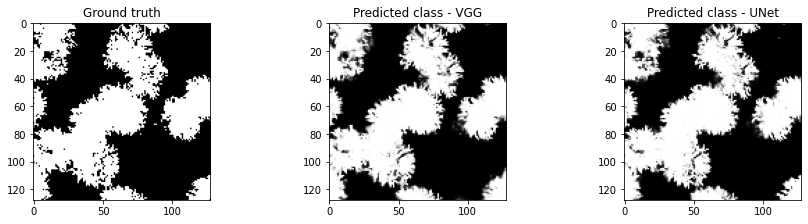

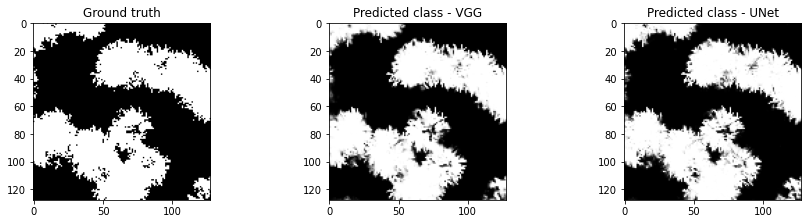

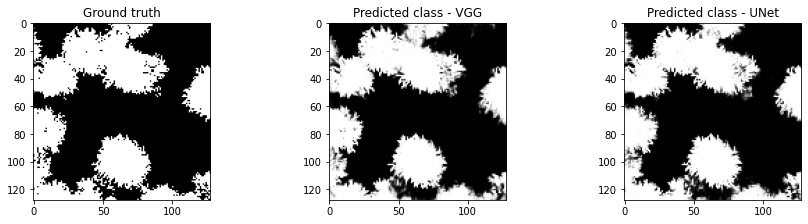

In [13]:
# Visualize model performance on validaton data for both models
i=1
tst = np.round(y_pred_vgg,0)
for num in range(3):   
    plt.figure(figsize = (15,15))
    plt.subplot(430+i) # Shorthand for size 3x3, position i
    i+=1
    image = y_test[num]*255
    plt.title('Ground truth')
    plt.imshow(image, cmap = 'gray')
    plt.subplot(430+i)
    i+=1
    image = y_pred_vgg[num]*255
    plt.title('Predicted class - VGG')
    plt.imshow(image, cmap = 'gray')
    plt.subplot(430+i)
    image = y_pred[num]*255
    plt.title('Predicted class - UNet')
    plt.imshow(image, cmap = 'gray')
    i+=1
plt.show()


We achieved accuracies between 94-96 % using different parameters on UNet and between 93 – 95% using VGG, which in itself is a high number. We can see from the resulting segmented images above that both models were able to segment birch trees from the others pretty accurately, however VGG missed the small details at some points and the predictions are more inaccurate around the edges. While UNet was able to classify more accurately.

In [14]:
#!/bin/bash
#SBATCH --ntasks=1			            	# 1 core (CPU)
#SBATCH --nodes=1			            	# Use 1 node
#SBATCH --job-name=g12_run_01	    # Name of job
#SBATCH --mem=3G 			            	# Default memory per CPU is 3GB
#SBATCH --partition=gpu                 	# Use the GPU partition
#SBATCH --gres=gpu:1                   		# Use only one GPU core
#SBATCH --mail-user=goran.sildnes.gedde-dahl@nmbu.no    		# Your email
#SBATCH --mail-type=ALL                     # Get notifications recarding your job
#SBATCH --output=outputs.out   # Output stored in this file

#===============================================================================
# This is a template for a slurm script. You need to modify this according to 
# your own experiments. You also need to choose appropriate 
# sbatch parameters above (how much memory you need is especially important).
#===============================================================================

## Script commands
module load singularity


## Define paths to relevant folders
DATADIR="$HOME/dat300/$1"
SIFFILE="$HOME/dat300/keras.sif"


## Temporary results should be saved in $TMPDIR. Here is an example:

## RUN THE PYTHON SCRIPT
# Runs a python script named run.py which takes one input argument (the data folder)
# Using a singularity container named keras.sif
singularity exec --nv $SIFFILE python dat300-ca2.py $DATADIR

SyntaxError: invalid syntax (1052967558.py, line 19)

# Discussion / conclusion

The training process was really exhausting as training the models required a lot of time. Testing different combinations of hyper parameters to find the best set of paramters for this assignment was a difficult process.

The model performed really well and showed excellent results with validation accuracies scores varying between 94 and 96 approximately. Unet performs really well for the given data.

If we had more time and resources we would have done the hyper parameter tuning by using techniques like grid search and random search CV to identify the best set of parameters that provides the best score instead of the hit and try approach we used.

For this task, I think Unet should be used instead of transfer learning VGG technique. Transfer learning should be used when we have huge amounts of data and not much computational power. For this task the data set was large but we had the necessary computational power to perform the analysis. We can see in our analysis that training the VGG network took almost the same time as training the the Unet model. There was only a difference of 6 seconds which is ignorable. Unet also shows slighlty better results which was predictable because Unet is trained on this particular problem and the weights are set according to this data while for VGG this was not the case.